In [51]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [52]:
#clearing the cache
!rm -rf /root/.torch/datasets/EMNIST
!rm -rf ./data/EMNIST


In [53]:
#available splits… so I know all the options I have lol
# "balanced": digits + letters (47 classes)
# "letters": only A–Z (26 classes)
# "digits": 0–9
# "byclass": 62 classes (digits + uppercase + lowercase)

split_style = 'balanced'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.EMNIST(
    root='./data',
    split=split_style, #where we can change the split
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.EMNIST(
    root='./data',
    split=split_style,
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


100%|██████████| 562M/562M [00:03<00:00, 166MB/s]


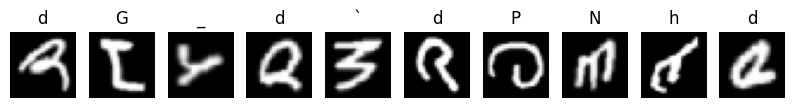

In [54]:
#a couple of samples so we get to see what it is

images, labels = next(iter(train_loader))
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(chr(labels[i]+64))  # labels go from 1–26
    plt.axis('off')
plt.show()


In [55]:
#the basic CNN

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        classNumber = 0; #switch casing for class size based on split
        if split_style == 'letters':
          classNumber = 26
        elif split_style == 'digits':
          classNumber = 10
        elif split_style == 'balanced':
          classNumber = 47
        elif split_style == 'byclass':
          classNumber = 62
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, classNumber)  #change second param to number of classes based on split

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [56]:
for _, labels in train_loader:
    print("min:", labels.min().item(), "max:", labels.max().item())
    print(labels[:32])  # print some labels
    break


min: 0 max: 45
tensor([30, 10, 10, 26, 19, 31, 15, 31, 15, 12,  9, 45, 25, 17, 39, 10,  4,  3,
        39, 11, 19,  1,  0, 22, 15,  9, 18, 19,  0, 14, 43, 23])


In [57]:
#training the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):  # train for 5 epochs to start
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        if split_style == 'letters':
            labels -= 1
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.6968
Epoch 2, Loss: 0.4061
Epoch 3, Loss: 0.3504
Epoch 4, Loss: 0.3150
Epoch 5, Loss: 0.2878


In [58]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Adjust labels to be 0-indexed for consistency with training and model output
        if split_style == 'letters':
            labels -= 1
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 86.64%
